In [1]:
from gurobipy import *
import numpy  as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import copy
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {}

In [2]:
def to_numpy(gurobi_variable):
    temp = [gurobi_variable[i].x for i in gurobi_variable.keys()]
    return np.asarray(temp)

def MasterProblem(horizon=20, init_vol=[1000, 1000, 1000]):
    # Create Model 
    m = Model("MP")

    upper_volume = 1200 # Volume limits.

    basins  = [i for i in range(0, 3)]
    max_threshold  = [10*horizon, 10*horizon, 2*horizon]
    # Create Basin Volume
    volume_basins = m.addVars(basins, lb=0, ub=upper_volume, vtype=GRB.CONTINUOUS, name="Volume_Basin")
    # Create Volume Exchange 
    volume_links  = m.addVars(basins, lb=0, ub=max_threshold, vtype=GRB.CONTINUOUS, name="Volume_Link")
    # Constraints 
    ## 1. Link and basin upper bound constraint set in variable. 
    ## 2. Mass Balance constraint 
    m.addConstr(volume_basins[0] == init_vol[0] - volume_links[0], "P0")
    m.addConstr(volume_basins[1] == init_vol[1] - volume_links[1], "P1")
    m.addConstr(volume_basins[2] == init_vol[2] + volume_links[0] + volume_links[1] - volume_links[2], "P1")
    m.setObjective(volume_basins.sum(), GRB.MINIMIZE)
    m.optimize()
    return to_numpy(volume_links)

def Subproblem(Volume_Links, init_vol, inflows, horizon_time=20):
    # Common Containers and variables
    obj = GRB.MINIMIZE
    horizon  = [time for time in range(0, horizon_time)]  # Time steps

    # Pond1 -> Generate outflows
    ## Variables 
    m_p1       = Model("Pond1")
    volume_p1  = m_p1.addVars(horizon, lb=0, ub=1200, vtype=GRB.CONTINUOUS, name="Volume")
    outflow_p1 = m_p1.addVars(horizon, lb=0, ub=10 , vtype=GRB.CONTINUOUS, name="Outflows")

    # Constarints 
    m_p1.addConstr(volume_p1[0]      == init_vol[0], "Inital Volume")
    m_p1.addConstr(outflow_p1.sum()  <= Volume_Links[0], "Total Mass Movement")
    m_p1.addConstrs((volume_p1[time] == volume_p1[time-1] - outflow_p1[time-1] for time in horizon[1:]), name="Mass balance")
    m_p1.addConstrs(outflow_p1[time] <= (volume_p1[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

    # Objective 
    m_p1.setObjective(volume_p1.sum(), obj)
    m_p1.optimize()


    # Pond2 -> Generate Outflows 
    ## Variables 
    m_p2       = Model("Pond2")
    volume_p2  = m_p2.addVars(horizon, lb=0, ub=1200, vtype=GRB.CONTINUOUS, name="Volume")
    outflow_p2 = m_p2.addVars(horizon, lb=0, ub=10 , vtype=GRB.CONTINUOUS, name="Outflows")

    # Constarints 
    m_p2.addConstr(volume_p2[0]      == init_vol[1], "Inital Volume")
    m_p2.addConstr(outflow_p2.sum()  <= Volume_Links[1], "Total Mass Movement")
    m_p2.addConstrs((volume_p2[time] == volume_p2[time-1] - outflow_p2[time-1] for time in horizon[1:]), name="Mass balance")
    m_p2.addConstrs(outflow_p2[time] <= (volume_p2[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

    # Objective 
    m_p2.setObjective(volume_p2.sum(), obj)
    m_p2.optimize()


    # Pond3 -> Take in the outflows and plan how you want to release them.
    ## Generate the outflows from the above into the downstream 
    inflow_p1    = to_numpy(outflow_p1)
    inflow_p2    = to_numpy(outflow_p2)
    inflows[10:] = inflows[10:] + inflow_p1[:10] + inflow_p2[:10]  # Travel time inserted here. 

    m_p3       = Model("Pond3")
    volume_p3  = m_p3.addVars(horizon, lb=0, ub=1200, vtype=GRB.CONTINUOUS, name="Volume")
    outflow_p3 = m_p3.addVars(horizon, lb=0, ub=2 , vtype=GRB.CONTINUOUS, name="Outflows")
    # Constarints
    m_p3.addConstr(volume_p3[0]      == init_vol[2] + inflows[0], "Inital Volume")
    m_p3.addConstr(outflow_p3.sum()  <= Volume_Links[2], "Total Mass Movement")
    m_p3.addConstrs((volume_p3[time] == volume_p3[time-1] - outflow_p3[time-1] + inflows[time] for time in horizon[1:]), name="Mass balance")
    m_p3.addConstrs(outflow_p3[time] <= (volume_p3[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

    # Objective 
    m_p3.setObjective(volume_p3.sum(), obj)
    m_p3.optimize()

    data = {}
    data["P1"] = {"volume":to_numpy(volume_p1), "outflow":to_numpy(outflow_p1)}
    data["P2"] = {"volume":to_numpy(volume_p2), "outflow":to_numpy(outflow_p2)}
    data["P3"] = {"volume":to_numpy(volume_p3), "outflow":to_numpy(outflow_p3)}
    return data, inflows


# Create water in the system
INIT_VOLUME = [5, 5, 0]

In [3]:
DATA = []
# Iteration 1
volume_links = MasterProblem(20, INIT_VOLUME)
print(volume_links)
inflows = np.zeros(20)
data, inflows = Subproblem(volume_links, INIT_VOLUME, inflows)
DATA.append(data)
for t in range(0,30):
    print("-----------------------------", t)
    INIT_VOLUME = [data["P1"]["volume"][10], data["P2"]["volume"][10], data["P3"]["volume"][10]]
    volume_links = MasterProblem(20, INIT_VOLUME)
    data, inflows = Subproblem(volume_links, INIT_VOLUME, inflows)
    DATA.append(data)
    
    temp = copy.deepcopy(inflows[10:])
    inflows = np.zeros(20)
    inflows[:10] = temp

Academic license - for non-commercial use only
Optimize a model with 3 rows, 6 columns and 8 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [4e+01, 1e+03]
  RHS range        [5e+00, 5e+00]
Presolve removed 3 rows and 6 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
[ 5.  5. 10.]
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [2e+00, 5e+00]
Presolve removed 19 rows and 18 columns
Presolve time: 0.01s
Presolved: 21 rows, 22 columns, 103 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5938600e+00   3.40


Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 1e+03]
  RHS range        [2e+00, 1e+01]
Presolve removed 18 rows and 17 columns
Presolve time: 0.01s
Presolved: 22 rows, 23 columns, 95 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8907900e+00   1.310921e+01   0.000000e+00      0s
       7    3.0767374e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds
Optimal objective  3.076737422e+01
----------------------------- 3
Optimize a model with 3 rows, 6 columns and 8 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [4e+01, 1e+03]
  RHS range        [0e+00, 0e+00]
Presolve removed 3 rows and 6 columns
Presolve time: 0.01s
Presolve: All rows and co

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
----------------------------- 7
Optimize a model with 3 rows, 6 columns

       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objec

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient 

       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objec

  Objective range  [1e+00, 1e+00]
  Bounds range     [4e+01, 1e+03]
  RHS range        [0e+00, 0e+00]
Presolve removed 3 rows and 6 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient st


Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
----------------------------- 26
Optimize a model with 3 rows, 6 columns and 8 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [4e+01, 1e+03]
  RHS range        [0e+00, 0e+00]
Presolve removed 3 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.  

  RHS range        [2e+00, 2e+00]
Presolve removed 40 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  0.000000000e+00


In [4]:
# Stack the things
volume_1 = DATA[0]["P1"]["volume"][:10]
for i in range(1, len(DATA)):
    volume_1 = np.append(volume_1, DATA[i]["P1"]["volume"][:10])
    
volume_2 = DATA[0]["P2"]["volume"][:10]
for i in range(1, len(DATA)):
    volume_2 = np.append(volume_2, DATA[i]["P2"]["volume"][:10])
    
volume_3= DATA[0]["P3"]["volume"][:10]
for i in range(1, len(DATA)):
    volume_3 = np.append(volume_3, DATA[i]["P3"]["volume"][:10])

outflow_1 = DATA[0]["P1"]["outflow"][:10]
for i in range(1, len(DATA)):
    outflow_1 = np.append(outflow_1, DATA[i]["P1"]["outflow"][:10])
    
outflow_2 = DATA[0]["P2"]["outflow"][:10]
for i in range(1, len(DATA)):
    outflow_2 = np.append(outflow_2, DATA[i]["P2"]["outflow"][:10])
    
outflow_3= DATA[0]["P3"]["outflow"][:10]
for i in range(1, len(DATA)):
    outflow_3 = np.append(outflow_3, DATA[i]["P3"]["outflow"][:10])

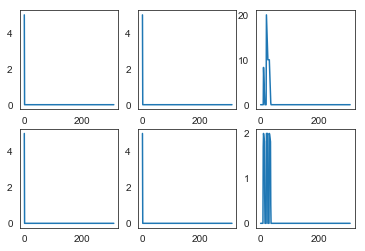

In [5]:
plt.subplot(2,3,1)
plt.plot(volume_1)
plt.subplot(2,3,2)
plt.plot(volume_2)
plt.subplot(2,3,3)
plt.plot(volume_3)
plt.subplot(2,3,4)
plt.plot(outflow_1)
plt.subplot(2,3,5)
plt.plot(outflow_2)
plt.subplot(2,3,6)
plt.plot(outflow_3)